# **1. 데이터 준비 및 EDA**

In [6]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [7]:
books = pd.read_csv('2024_books.csv')
reviews = pd.read_csv('new_reviews.csv')

In [8]:
books.shape, reviews.shape

((778, 13), (22689, 4))

In [9]:
display(reviews.head(2))
display(books.head(2))

userId                                             review    평점  \
0  tj******         첫 이유식 시작 한달 전에 구매하서 도움 많이 받았어요. 잘 시작해볼게요^^  10.0   
1    eo****  아기가 5개월이 다 되어가서 이유식준비를 앞두고 미리 사서 읽어보았아요. 도움이 됩니다.  10.0   

          bookId  
0  S000001967752  
1  S000001967752

순위           상품코드         판매상품ID                      상품명      정가     판매가  \
0   1  9791193506202  S000212053843            아이는 무엇으로 자라는가  17,500  15,750   
1   2  9788915999008  S000213747758  임신 출산 육아 대백과(2024-2025)  19,500  17,550   

   할인율 적립율 적립예정포인트         인물     출판사      발행일자     분야  
0  10%  5%     870   버지니아 사티어  포레스트북스  20231218  가정/육아  
1  10%  5%     970  삼성출판사 편집부   삼성출판사  20240715  가정/육아

- 활용할 도서 분야 5종과 각 분야별 리뷰 수

In [10]:
bold = '\033[1m'
reset = '\033[0m'
merge_df = pd.merge(reviews, books, left_on='bookId', right_on='판매상품ID')

print(f"{bold}[분야별 고유 도서(bookId) 개수:]{reset}")
display(pd.DataFrame(merge_df.groupby('분야')['bookId'].nunique()))
print()
print(f"{bold}[분야별 도서 리뷰 건수:]{reset}")
display(pd.DataFrame(merge_df.groupby('분야')['review'].nunique()))

[분야별 고유 도서(bookId) 개수:]


bookId
분야              
가정/육아         30
어린이(초등)       60
요리            30
유아(0~7세)      30
청소년           29


[분야별 도서 리뷰 건수:]


review
분야              
가정/육아       2998
어린이(초등)     7857
요리          1791
유아(0~7세)    3031
청소년         5130

- 유저별 리뷰 수 분포

In [11]:
idx, val= np.unique(merge_df['userId'], return_counts=True)

print('리뷰를 1건 남긴 유저:', len(idx) - len(idx[val > 1]),'명')
print('리뷰를 2건 이상 남긴 유저:', len(idx[val > 1]),'명')
print('리뷰를 5건 이상 남긴 유저:', len(idx[val > 4]),'명')
print('리뷰를 10건 이상 남긴 유저:', len(idx[val > 9]),'명')

리뷰를 1건 남긴 유저: 1080 명
리뷰를 2건 이상 남긴 유저: 2077 명
리뷰를 5건 이상 남긴 유저: 1167 명
리뷰를 10건 이상 남긴 유저: 660 명


- 크롤링한 데이터만 이용할 수 있다는 한계점으로 마스킹된 아이디를 유저아이디로 사용하고자 함
- 마스킹된 유저 아이디가 리뷰를 n건 남겼기 때문에 협업 필터링과 콘텐츠 기반 필터링을 결합한 하이브리드 추천시스템 구현이 가능



# **2. 책별로 중요한 리뷰 상위 10개 키워드 추출**

* 각 책별로 리뷰를 **합치고**,
  **표제어 토큰화 및 불용어 제거** 후
  **상위 10개 키워드**를 추출

---

## 🔧 **\[방법 : KiWi 라이브러리 활용]**

* **KiWi** 라이브러리는 자연어 처리(NLP) 분야에서 특히 **한국어 형태소 분석에 효과적인 도구**
* 🎯 **목표** : 한국어 리뷰 텍스트에서 **주요 키워드 추출하기** – KiWi와 soynlp를 활용한 **전처리 및 분석**

---

## 📝 **\[수행과정]**

* **요약** : 책별로 리뷰를 **연결해서 토큰화**하여 **의미있는 단어 빈도수**를 셈

---

#### 1️⃣ **반복 문자 정제화**: 감정 표현 과장 줄이기 (정규표현식)

* 예시: 진짜 좋아요ㅋㅋㅋㅋ → 진짜 좋아요ㅋㅋ

---

#### 2️⃣ **형태소 분석 및 표제어 추출 (KiWi)**

* **KiWi** 라이브러리를 사용해 문장을 **토큰화**하고, **의미 있는 품사만 추출**
* 📌 **사용한 품사** : 일반 명사, 고유 명사, 대명사, 일반 부사, 형용사 어간
* 동사 같은 **이외의 품사도 처음에는 적용하였으나**,
  **불필요한 의미로 파악되어** 확인하며 사용할 품사를 조절하였음

---

#### 3️⃣ **불용어 제거**

* 필요없는 단어들을 **제외**하고,
  남은 단어들을 **빈도수 기준으로 정렬**

---

#### 4️⃣ **키워드를 정리한 최종 데이터프레임 생성**
---

In [12]:
# 책별로 리뷰 연결하기
result = reviews.groupby('bookId')['review'].apply(lambda x: '_'.join(x)).reset_index()

In [13]:
result['review'] = result['review'].replace('[^ㄱ-ㅎ가-힣 ]', '', regex=True) # 순수히 한국어만, 띄어쓰기 필요해서 공백 하나 넣었고, 특스문자도 필요하면 특수문자도 붙여주기 ㄱ-하-ㅣ가-힣 .,/
result['review'] = result['review'].replace('^ +', '', regex=True) # 공백 1개 이상일 때, 공백 제거 '^ +'
result['review'] = result['review'].replace('', np.nan)
result = result.dropna()
result = result.reset_index(drop=True)
result

bookId                                             review
0    S000000554988  진정으로 찾고 있던 책을 만난느낌 나는 레시피를 그대로 따라하는데 왜 사진처럼 또는...
1    S000000555409  리터 와인병을 매그넘이라고 합니다 그만큼 전편보다 많은 내용을 담고 있겠지요 풍부한...
2    S000000597566  교보에서 책을 시작한 것이 년이 넘었지만 이렇게 선뜻 리뷰를 먼저 쓰기는 처음입니다...
3    S000000597842  실생활에 사용되고 필요한 내용이지만심도있지는 않아요 이 상황에 어떻게 말해야한다 딱...
4    S000000611323  아이 키우는 친구가 추천해줘서 구입했어요 대 중반 성인여잔데 일상의 위로를 받을 수...
..             ...                                                ...
174  S000214094381  내용은 좋습니다만 초보자용은 아니예요 구움과자 좀 해본 분이 더 향상시키기 위한 그...
175  S000214106784  사자마자 다 읽었어요아이가 좋아해요 권도 궁금하네요아이가 아주 좋아해요재미있게 보고...
176  S000214299107  아이를 대할 때의 내 마음가짐을 바꿔보고 싶었습니다 아이와 함께 하는 일들을 퀘스트...
177  S000214299207  아이가 재미있어해요스도쿠를 재밌게 해볼 수 있어요아이가 서점에서 이 책을 보느라 안...
178  S000214512007  아이가 보고 고른 책이예요고등학생이 될 조카를 잘 가르쳐 보고 싶어서 구매했어요아이...

[179 rows x 2 columns]

In [19]:
# 반복 문자 정제화 3개까지
from soynlp import *
from soynlp.normalizer import repeat_normalize
import re

def custom_repeat_normalize(text, num_repeats=2):
    return re.sub(r'(.)\1{'+str(num_repeats)+',}', lambda m: m.group(1)*num_repeats, text)

result['review'] =result['review'].apply(lambda text: custom_repeat_normalize(text, num_repeats=2))

# 표제어 + 토큰화 
from kiwipiepy import Kiwi

kiwi = Kiwi()
sents = result['review']

keep_tags = {
      'NNG'  # 일반 명사
     ,'NNP'  # 고유명사
     ,'NP'   # 대명사
     ,'MAG'  # 일반 부사
     ,'VA'   # 형용사 어간
}

X_data = [
    [t.lemma for t in kiwi.tokenize(sent) if t.tag in keep_tags]
    for sent in result['review']
]

from collections import Counter

# 불용어(제외할 단어) 리스트 예시
stopwords = {'있다', '같다', '내용', '구매','없다','팅','신천지','잘','너무','많다','때','안'}

book_keywords = {}
for book_id, tokens in zip(result['bookId'], X_data):
    filtered_tokens = [token for token in tokens if token not in stopwords]
    token_counts = Counter(filtered_tokens)
    top_10 = token_counts.most_common(10)
    book_keywords[book_id] = top_10

# 각 bookId별로 키워드 리스트만 추출해서 DataFrame 생성
book_keyword_df = pd.DataFrame(
    [(book_id, [word for word, count in keywords]) for book_id, keywords in book_keywords.items()],
    columns=['bookId', 'keywords']
)

book_keyword_df

bookId                                      keywords
0    S000000554988        [요리, 책, 좋다, 과학, 추천, 도움, 설명, 기본, 유용, 왜]
1    S000000555409      [와인, 좋다, 책, 추천, 입문서, 공부, 유용, 입문, 도움, 정리]
2    S000000597566      [책, 좋다, 요리, 집밥, 가족, 밥, 마음, 이재명, 사랑, 맛있다]
3    S000000597842       [책, 좋다, 아이, 도움, 말, 육아, 많이, 오은영, 박사, 생각]
4    S000000611323  [아이, 좋다, 책, 수박, 그림, 여름, 재미있다, 수영장, 상상력, 예쁘다]
..             ...                                           ...
174  S000214094381       [책, 좋다, 도움, 감사, 좀, 정말, 레시피, 높다, 많이, 과자]
175  S000214106784   [아이, 재미있다, 좋다, 책, 재밌다, 유튜브, 유튜버, 권, 아주, 생일]
176  S000214299107      [아이, 책, 마음, 좋다, 육아, 부모, 도움, 아기, 박소영, 기대]
177  S000214299207   [아이, 시리즈, 좋다, 책, 재미있다, 재밌다, 스도쿠, 다, 구입, 바로]
178  S000214512007      [책, 도움, 아이, 공부, 좋다, 많이, 딸, 프로그램, 배송, 구입]

[179 rows x 2 columns]

# **3. 콘텐츠 + 협업 => 하이브리드 추천시스템**
- 협업 필터링(SVD)과 내용 기반 추천(TF-IDF, 코사인 유사도)
두 가지 방식을 결합한 하이브리드 추천 시스템을 구현

## **[수행 과정]**
1. 도서 카테고리 기반 유사도 측정
2. 도서 제목 기반 유사도 측정
3. 모델 튜닝

## **[결과]**
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

📚  **tj******님이 구매한 책: 「삐뽀삐뽀 119 이유식」**

**1안** ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

1. 📖 최강록의 요리 노트
   🔑 [키워드: 좋다, 요리, 책, 록, 최강, 도움, 설명, 쉐프, 많이, 재밌다]

2. 📖 베이킹은 과학이다: 제빵편
   🔑 [키워드: 좋다, 책, 베이킹, 제빵, 빵, 설명, 도움, 제과, 많이, 공부]

3. 📖 셰프의 가벼운 레스토랑
   🔑 [키워드: 요리, 책, 좋다, 건강, 사월, 맛있다, 진짜, 유용, 체중, 꿀]

**2안** ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

1. 📖 삐뽀삐뽀 119 소아과
   🔑 [키워드: 책, 좋다, 도움, 육아, 유용, 아이, 많이, 아기, 선물, 정보]

2. 📖 튼이 이유식
   🔑 [키워드: 이유식, 책, 좋다, 도움, 시작, 설명, 준비, 많이, 아기, 유용]

3. 📖 뿐이 토핑 이유식
   🔑 [키워드: 이유식, 도움, 좋다, 책, 시작, 토핑, 많이, 블로그, 그대로, 유식]

**2안+모델 튜닝** ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
1. 📖 삐뽀삐뽀 119 소아과
   🔑 [키워드: 책, 좋다, 도움, 육아, 유용, 아이, 많이, 아기, 선물, 정보]

2. 📖 튼이 이유식
   🔑 [키워드: 이유식, 책, 좋다, 도움, 시작, 설명, 준비, 많이, 아기, 유용]

3. 📖 뿐이 토핑 이유식
   🔑 [키워드: 이유식, 도움, 좋다, 책, 시작, 토핑, 많이, 블로그, 그대로, 유식]

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
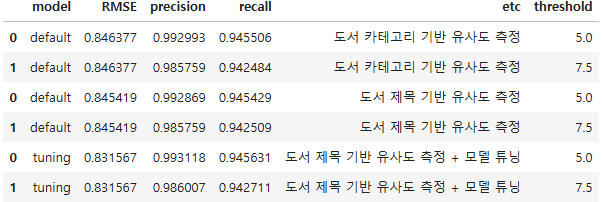    

**참고로 y값인 구매자 평점이 2.5, 5.0, 10.0으로만 구성되어 y를 연속형으로 예측한 값은 RMSE로 평가하였고, 도출된 연속형 평점을 임계값을 기준으로 긍정/부정 이진변수화하여 평가한 값은 Precision, Recall로 평가하였습니다.**

In [22]:
#기본연산모듈
import numpy as np
import pandas as pd
#협업 필터링을 위한 모듈
from surprise import Dataset,Reader, SVD
from surprise.model_selection import train_test_split
#내용 기반을 위한 모듈
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [97]:
merge_df.head(1)

userId                                      review    평점         bookId  \
0  tj******  첫 이유식 시작 한달 전에 구매하서 도움 많이 받았어요. 잘 시작해볼게요^^  10.0  S000001967752   

   순위           상품코드         판매상품ID           상품명      정가     판매가  할인율 적립율  \
0   1  9791195795529  S000001967752  삐뽀삐뽀 119 이유식  18,900  17,010  10%  5%   

  적립예정포인트   인물   출판사      발행일자  분야  
0     940  하정훈  유니책방  20171201  요리

In [98]:
print(f"평점은 {merge_df['평점'].min()}부터 {merge_df['평점'].max()}까지 {sorted(merge_df['평점'].unique())}로 구성되어 있습니다.")

평점은 2.5부터 10.0까지 [2.5, 5.0, 7.5, 10.0]로 구성되어 있습니다.


### 1. 추천시스템을 위한 데이터셋 준비

In [23]:
from surprise import Dataset, Reader, model_selection

reader = Reader(rating_scale=(2.5, 10.0))
data = Dataset.load_from_df(reviews[['userId', 'bookId', '평점']], reader)
tr_ds, tt_ds = model_selection.train_test_split(data, test_size=0.2, random_state=42)

### 2. 도서 카테고리 기반 유사도 측정

In [24]:
# 협업 필터링(SVD) : 행렬 분해 기반 추천 모델(사용자-아이템 평점 예측)
m_category = SVD()
m_category.fit(tr_ds)

# 내용 기반 추천
## 도서 분야를 벡터화하고 도서 간 유사도 계산
tf_idf_v = TfidfVectorizer()
tf_idf_d = tf_idf_v.fit_transform(books['분야'])
c1 = cosine_similarity(tf_idf_d, tf_idf_d)

# 도서 ID 매핑
book_idx_map = dict(zip(books['판매상품ID'], books.index))
title_to_bookId_map = dict(zip(books['상품명'], books['판매상품ID']))

In [25]:
# 하이브리드 추천 함수

def 추천(user_id, title, top_n=5, alpha=0.5):
    t_m_id = title_to_bookId_map[title]  # 도서 제목으로 도서ID 찾기
    t_idx = book_idx_map[t_m_id]         # 도서ID로 데이터프레임의 인덱스 찾기
    sim_sc = list(enumerate(c1[t_idx]))  # 유사도 리스트

    hy_score = []
    for idx, sim in sim_sc:
        recommend_book_id = books['판매상품ID'].iloc[idx]
        try:
            p_r = m_category.predict(user_id, recommend_book_id).est  # 협업 필터링 예측
            sc = alpha * sim + (1 - alpha) * (p_r / 10.0)
            hy_score.append((idx, sc))
        except:
            continue

    hy_score.sort(key=lambda x: x[1], reverse=True)  # 점수 기준 내림차순 정렬
    top_i = [idx for idx, _ in hy_score[1:top_n+1]]  # 자기 자신(0번째) 제외, top_n개
    return books['상품명'].iloc[top_i]

In [26]:
bold = '\033[1m'
reset = '\033[0m'

userid = 'tj******'
user_b_book = books[books['판매상품ID']=='S000001967752']['상품명'].iloc[0]
recommend_book_l = 추천(userid, user_b_book , top_n=3, alpha=0.5)   # 하이브리드 추천

print('━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━')
print()
print(f'📚  {bold}{userid}{reset}님이 구매한 책: {bold}「{user_b_book}」{reset}')
print()
print('━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━')
print(f'{bold}✨ 다른 베스트셀러를 추천드려요! ✨{reset}')
print()

for i, book in enumerate(recommend_book_l, 1):
    # 추천 도서의 bookId 찾기
    book_id = books[books['상품명'] == book]['판매상품ID'].iloc[0]
    # 키워드 찾기 (없으면 빈 리스트)
    keywords = book_keyword_df[book_keyword_df['bookId'] == book_id]['keywords']
    keywords_str = ', '.join(keywords.iloc[0]) if not keywords.empty else '(키워드 없음)'
    print(f"{i}. 📖 {book}")
    print(f"   🔑 [키워드: {keywords_str}]")
    print()
print('━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━')

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

📚  tj******님이 구매한 책: 「삐뽀삐뽀 119 이유식」

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
✨ 다른 베스트셀러를 추천드려요! ✨

1. 📖 밥을 지어요
   🔑 [키워드: 책, 좋다, 요리, 집밥, 가족, 밥, 마음, 이재명, 사랑, 맛있다]

2. 📖 샐러드에 반하다
   🔑 [키워드: 좋다, 샐러드, 책, 레시피, 다양, 요리, 식단, 많이, 예쁘다, 도움되요]

3. 📖 김대석 셰프의 집밥 레시피
   🔑 [키워드: 좋다, 책, 요리, 추천, 레시피, 도움, 엄마, 선물, 집밥, 재미있다]

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━


In [27]:
def precision_recall_at_k(predictions, k=5, threshold=7.5):
    '''Precision@K and Recall@K for each user'''
    from collections import defaultdict

    # 1. 유저별로 예측 평점과 실제 평점을 저장할 딕셔너리 생성
    user_est_true = defaultdict(list)
    for pred in predictions:
        # pred.uid: 사용자ID, pred.est: 예측 평점, pred.r_ui: 실제 평점
        user_est_true[pred.uid].append((pred.est, pred.r_ui))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():
        # 2. 예측 평점 기준으로 내림차순 정렬 (추천 리스트 만들기)
        user_ratings.sort(key=lambda x: x[0], reverse=True)
        # 3. Top-K 추천 아이템만 추출
        top_k = user_ratings[:k]
        # 4. 실제 평점이 threshold 이상인 아이템(좋아한 아이템) 개수
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)
        # 5. 추천 Top-K 중 예측 평점이 threshold 이상인 아이템 개수
        n_rec_k = sum((est >= threshold) for (est, _) in top_k)
        # 6. 추천 Top-K 중 실제로도 좋아한 아이템 개수
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold)) for (est, true_r) in top_k)

        # 7. Precision@K, Recall@K 계산
        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0
        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    # 8. 전체 유저의 평균 Precision@K, Recall@K 계산
    mean_precision = sum(prec for prec in precisions.values()) / len(precisions)
    mean_recall = sum(rec for rec in recalls.values()) / len(recalls)
    return mean_precision, mean_recall

In [28]:
from surprise import accuracy

results = []

# 1) 도서 카테고리 기반 유사도 측정
predictions = m_category.test(tt_ds)  # m_title: 도서 제목 기반 모델
rmse_value = accuracy.rmse(predictions)
for th in [5.0, 7.5]:
    mean_precision, mean_recall = precision_recall_at_k(predictions, k=5, threshold=th)
    results.append({
        'model': 'default',
        'RMSE': rmse_value,
        'precision': mean_precision,
        'recall': mean_recall,
        'etc': '도서 카테고리 기반 유사도 측정',
        'threshold': th
    })

# DataFrame으로 변환
import pandas as pd
model_score_df = pd.DataFrame(results)
model_score_df

RMSE: 0.8455


model      RMSE  precision    recall                etc  threshold
0  default  0.845458   0.992869  0.945491  도서 카테고리 기반 유사도 측정        5.0
1  default  0.845458   0.985510  0.942343  도서 카테고리 기반 유사도 측정        7.5

### 2. 도서 제목 유사도

In [29]:
# 협업 필터링(SVD) : 행렬 분해 기반 추천 모델(사용자-아이템 평점 예측)
m_title = SVD()
m_title.fit(tr_ds)

# 내용 기반 추천
## 도서 분야를 벡터화하고 도서 간 유사도 계산
tf_idf_v = TfidfVectorizer()
tf_idf_d = tf_idf_v.fit_transform(books['상품명'])
c1 = cosine_similarity(tf_idf_d, tf_idf_d)

# 도서 ID 매핑
book_idx_map = dict(zip(books['판매상품ID'], books.index))
title_to_bookId_map = dict(zip(books['상품명'], books['판매상품ID']))

In [30]:
# 하이브리드 추천 함수

def 추천(user_id, title, top_n=5, alpha=0.5):
    t_m_id = title_to_bookId_map[title]  # 도서 제목으로 도서ID 찾기
    t_idx = book_idx_map[t_m_id]         # 도서ID로 데이터프레임의 인덱스 찾기
    sim_sc = list(enumerate(c1[t_idx]))  # 유사도 리스트

    hy_score = []
    for idx, sim in sim_sc:
        recommend_book_id = books['판매상품ID'].iloc[idx]
        try:
            p_r = m_title.predict(user_id, recommend_book_id).est  # 협업 필터링 예측
            sc = alpha * sim + (1 - alpha) * (p_r /  10.0)
            hy_score.append((idx, sc))
        except:
            continue

    hy_score.sort(key=lambda x: x[1], reverse=True)  # 점수 기준 내림차순 정렬
    top_i = [idx for idx, _ in hy_score[1:top_n+1]]  # 자기 자신(0번째) 제외, top_n개
    return books['상품명'].iloc[top_i]

In [31]:
bold = '\033[1m'
reset = '\033[0m'

userid = 'tj******'
user_b_book = books[books['판매상품ID']=='S000001967752']['상품명'].iloc[0]
recommend_book_l = 추천(userid, user_b_book , top_n=3, alpha=0.5)   # 하이브리드 추천

print('━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━')
print()
print(f'📚  {bold}{userid}{reset}님이 구매한 책: {bold}「{user_b_book}」{reset}')
print()
print('━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━')
print(f'{bold}✨ 다른 베스트셀러를 추천드려요! ✨{reset}')
print()

for i, book in enumerate(recommend_book_l, 1):
    # 추천 도서의 bookId 찾기
    book_id = books[books['상품명'] == book]['판매상품ID'].iloc[0]
    # 키워드 찾기 (없으면 빈 리스트)
    keywords = book_keyword_df[book_keyword_df['bookId'] == book_id]['keywords']
    keywords_str = ', '.join(keywords.iloc[0]) if not keywords.empty else '(키워드 없음)'
    print(f"{i}. 📖 {book}")
    print(f"   🔑 [키워드: {keywords_str}]")
    print()
print('━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━')

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

📚  tj******님이 구매한 책: 「삐뽀삐뽀 119 이유식」

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
✨ 다른 베스트셀러를 추천드려요! ✨

1. 📖 삐뽀삐뽀 119 소아과
   🔑 [키워드: 책, 좋다, 도움, 육아, 유용, 아이, 많이, 아기, 선물, 정보]

2. 📖 튼이 이유식
   🔑 [키워드: 이유식, 책, 좋다, 도움, 시작, 설명, 준비, 많이, 아기, 유용]

3. 📖 뿐이 토핑 이유식
   🔑 [키워드: 이유식, 도움, 좋다, 책, 시작, 토핑, 많이, 블로그, 그대로, 유식]

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━


In [32]:
from surprise import accuracy

results = []

# 2) 도서 제목 기반 유사도 측정
predictions = m_title.test(tt_ds)  # m_title: 도서 제목 기반 모델
rmse_value = accuracy.rmse(predictions)
for th in [5.0, 7.5]:
    mean_precision, mean_recall = precision_recall_at_k(predictions, k=5, threshold=th)
    results.append({
        'model': 'default',
        'RMSE': rmse_value,
        'precision': mean_precision,
        'recall': mean_recall,
        'etc': '도서 제목 기반 유사도 측정',
        'threshold': th
    })

# DataFrame으로 변환
import pandas as pd
model_score_df2 = pd.DataFrame(results)
model_score_df = pd.concat([model_score_df, model_score_df2], axis=0)
model_score_df

RMSE: 0.8468


model      RMSE  precision    recall                etc  threshold
0  default  0.845458   0.992869  0.945491  도서 카테고리 기반 유사도 측정        5.0
1  default  0.845458   0.985510  0.942343  도서 카테고리 기반 유사도 측정        7.5
0  default  0.846825   0.993118  0.945543    도서 제목 기반 유사도 측정        5.0
1  default  0.846825   0.985759  0.942481    도서 제목 기반 유사도 측정        7.5

### 3. 모델 성능 개선 -> 도서 제목 유사도 기반 채택하여 모델 튜닝

In [33]:
from surprise import Dataset, SVD
from surprise.model_selection import GridSearchCV

# 파라미터 그리드 정의
param_grid = {
    'n_epochs': [5, 10],
    'lr_all': [0.002, 0.005],
    'reg_all': [0.4, 0.6]
}

# GridSearchCV 객체 생성 및 학습
gs = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=3)
gs.fit(data)

# 추천 알고리즘 (SVD)
best_params = gs.best_params['rmse']
model_tuning = SVD(**best_params)
model_tuning.fit(tr_ds)

# 내용 기반 추천
## 도서 분야를 벡터화하고 도서 간 유사도 계산
tf_idf_v = TfidfVectorizer()
tf_idf_d = tf_idf_v.fit_transform(books['상품명'])
c1 = cosine_similarity(tf_idf_d, tf_idf_d)

# 도서 ID 매핑
book_idx_map = dict(zip(books['판매상품ID'], books.index))
title_to_bookId_map = dict(zip(books['상품명'], books['판매상품ID']))

In [34]:
# 하이브리드 추천 함수

def 추천(user_id, title, top_n=5, alpha=0.5):
    t_m_id = title_to_bookId_map[title]  # 도서 제목으로 도서ID 찾기
    t_idx = book_idx_map[t_m_id]         # 도서ID로 데이터프레임의 인덱스 찾기
    sim_sc = list(enumerate(c1[t_idx]))  # 유사도 리스트

    hy_score = []
    for idx, sim in sim_sc:
        recommend_book_id = books['판매상품ID'].iloc[idx]
        try:
            p_r = model_tuning.predict(user_id, recommend_book_id).est  # 협업 필터링 예측
            sc = alpha * sim + (1 - alpha) * (p_r /  10.0)
            hy_score.append((idx, sc))
        except:
            continue

    hy_score.sort(key=lambda x: x[1], reverse=True)  # 점수 기준 내림차순 정렬
    top_i = [idx for idx, _ in hy_score[1:top_n+1]]  # 자기 자신(0번째) 제외, top_n개
    return books['상품명'].iloc[top_i]

In [35]:
bold = '\033[1m'
reset = '\033[0m'

userid = 'tj******'
user_b_book = books[books['판매상품ID']=='S000001967752']['상품명'].iloc[0]

recommend_book_l = 추천(userid, user_b_book , top_n=3, alpha=0.5)   # 하이브리드 추천

print('━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━')
print()
print(f'📚  {bold}{userid}{reset}님이 구매한 책: {bold}「{user_b_book}」{reset}')
print()
print('━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━')
print(f'{bold}✨ 다른 베스트셀러를 추천드려요! ✨{reset}')
print()

for i, book in enumerate(recommend_book_l, 1):
    # 추천 도서의 bookId 찾기
    book_id = books[books['상품명'] == book]['판매상품ID'].iloc[0]
    # 키워드 찾기 (없으면 빈 리스트)
    keywords = book_keyword_df[book_keyword_df['bookId'] == book_id]['keywords']
    keywords_str = ', '.join(keywords.iloc[0]) if not keywords.empty else '(키워드 없음)'
    print(f"{i}. 📖 {book}")
    print(f"   🔑 [키워드: {keywords_str}]")
    print()
print('━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━')

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

📚  tj******님이 구매한 책: 「삐뽀삐뽀 119 이유식」

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
✨ 다른 베스트셀러를 추천드려요! ✨

1. 📖 삐뽀삐뽀 119 소아과
   🔑 [키워드: 책, 좋다, 도움, 육아, 유용, 아이, 많이, 아기, 선물, 정보]

2. 📖 튼이 이유식
   🔑 [키워드: 이유식, 책, 좋다, 도움, 시작, 설명, 준비, 많이, 아기, 유용]

3. 📖 뿐이 토핑 이유식
   🔑 [키워드: 이유식, 도움, 좋다, 책, 시작, 토핑, 많이, 블로그, 그대로, 유식]

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━


In [36]:
from surprise import accuracy

results = []

# 2) 도서 제목 기반 유사도 측정
predictions = model_tuning.test(tt_ds)  # m_title: 도서 제목 기반 모델
rmse_value = accuracy.rmse(predictions)
for th in [5.0, 7.5]:
    mean_precision, mean_recall = precision_recall_at_k(predictions, k=5, threshold=th)
    results.append({
        'model': 'tuning',
        'RMSE': rmse_value,
        'precision': mean_precision,
        'recall': mean_recall,
        'etc': '도서 제목 기반 유사도 측정 + 모델 튜닝',
        'threshold': th
    })

# DataFrame으로 변환
import pandas as pd
model_score_df2 = pd.DataFrame(results)
model_score_df = pd.concat([model_score_df, model_score_df2], axis=0)
model_score_df

RMSE: 0.8318


model      RMSE  precision    recall                      etc  threshold
0  default  0.845458   0.992869  0.945491        도서 카테고리 기반 유사도 측정        5.0
1  default  0.845458   0.985510  0.942343        도서 카테고리 기반 유사도 측정        7.5
0  default  0.846825   0.993118  0.945543          도서 제목 기반 유사도 측정        5.0
1  default  0.846825   0.985759  0.942481          도서 제목 기반 유사도 측정        7.5
0   tuning  0.831797   0.993118  0.945631  도서 제목 기반 유사도 측정 + 모델 튜닝        5.0
1   tuning  0.831797   0.986007  0.942711  도서 제목 기반 유사도 측정 + 모델 튜닝        7.5